In [15]:
import warnings
import math
import keras
import h5py
import scipy
import PIL
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import pywt

import src.preprocess
import src.cwt_pywt

In [16]:
# Get EGG Data
data = src.preprocess.PreProcess("eeg")
train, valid = data.train_valid.train_valid_split(0.3)
x_train, y_train = train.raw
x_valid, y_valid = valid.raw
x_test, y_test = data.test.raw

# Bring to 0
y_train -= 769
y_valid -= 769
y_test -= 769

print(x_train.shape)

(1480, 22, 1000)


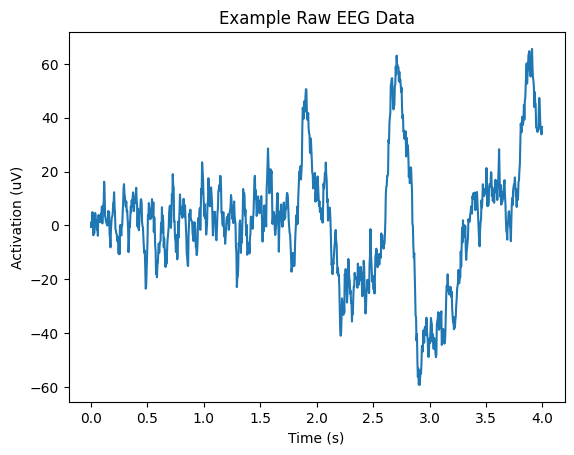

In [17]:
# Plot Example
t = np.arange(1000) / 250

plt.plot(t, x_train[0][0])
plt.ylabel("Activation (uV)")
plt.xlabel("Time (s)")
plt.title("Example Raw EEG Data")
plt.show()

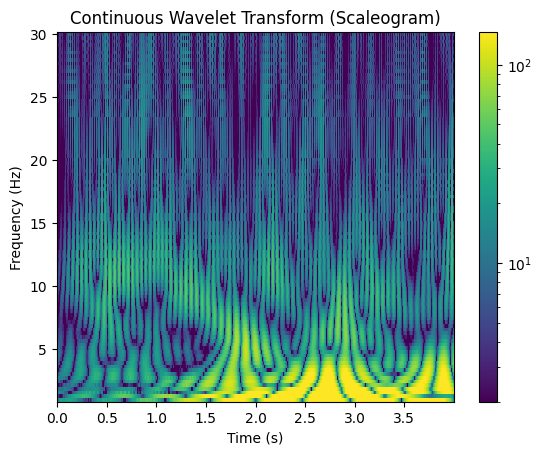

In [18]:
# Create an example CWT
base_cwt = src.cwt_pywt.CWT_PYWT(x_train[:1,0], wavelet = 'morl', vmin=2, vmax=146.1370777320306)
base_cwt.plot_n(0)

In [19]:
def CAR(x: np.ndarray):
    """
    Common Average Referencing

    Removes common internal and external noises by subtracting the mean of all 22 electrodes from each electrode.
    """
    new_ref = np.mean(x, axis=1)
    return x - new_ref.reshape((new_ref.shape[0], 1, new_ref.shape[1]))

x_train = CAR(x_train)
x_valid = CAR(x_valid)
x_test = CAR(x_test)

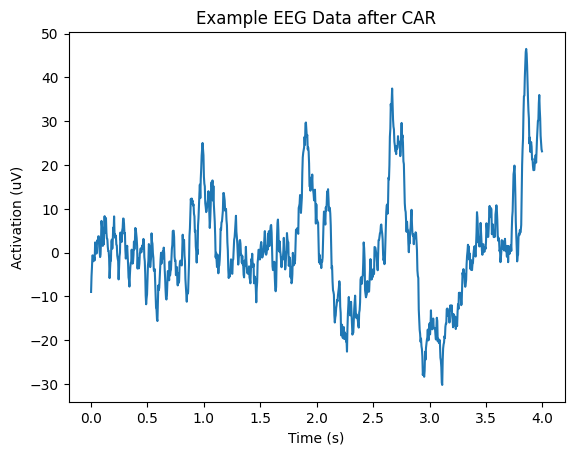

In [20]:
# Post CAR
t = np.arange(1000) / 250
plt.plot(t, x_train[0][0])
plt.ylabel("Activation (uV)")
plt.xlabel("Time (s)")
plt.title("Example EEG Data after CAR")
plt.show()

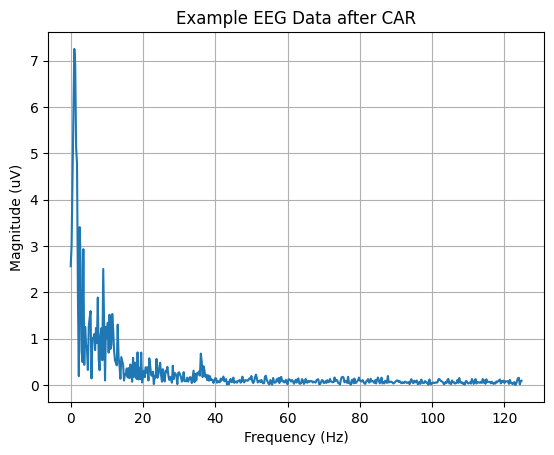

In [21]:
# sample spacing
T = 1.0 / 250
yf = scipy.fft.fft(x_train[0][0])
xf = scipy.fft.fftfreq(1000, 1/250)[:1000//2]

plt.plot(xf, 2.0/1000 * np.abs(yf[0:1000//2]))
plt.grid()
plt.ylabel("Magnitude (uV)")
plt.xlabel("Frequency (Hz)")
plt.title("Example EEG Data after CAR")
plt.show()

In [22]:
def erd_ers(x) -> np.ndarray:
    """
    Fifth-order zero-phase butter-worth filters isolates the Mu and Beta frequency bands.

    Mu: 8-14 Hz
    Beta: 15-30 Hz
    """
    num1, denom1 = scipy.signal.butter(5, [7, 30], btype='band', fs=250)
    
    ret = np.zeros_like(x)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            ret[i][j] = scipy.signal.filtfilt(num1, denom1, x[i][j])
    return ret

x_train = erd_ers(x_train)
x_valid = erd_ers(x_valid)
x_test = erd_ers(x_test)

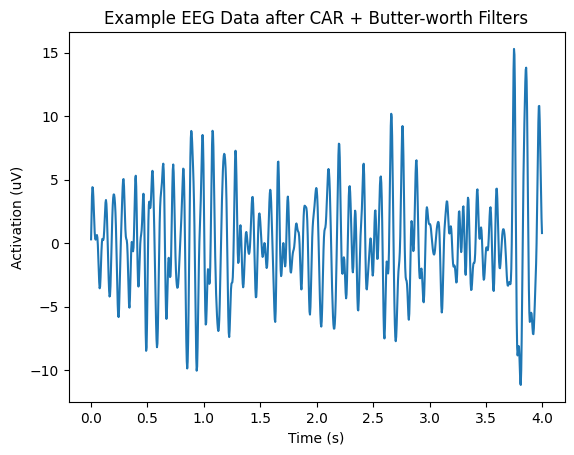

In [23]:
# Post Filter
t = np.arange(1000) / 250
plt.plot(t, x_train[0][0])
plt.ylabel("Activation (uV)")
plt.xlabel("Time (s)")
plt.title("Example EEG Data after CAR + Butter-worth Filters")
plt.show()

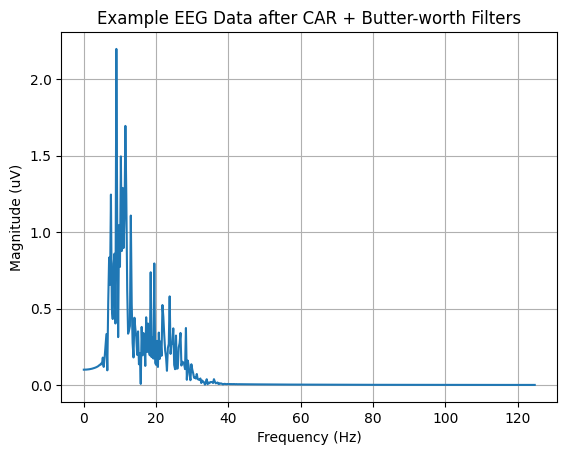

In [24]:
# sample spacing
T = 1.0 / 250
yf = scipy.fft.fft(x_train[0][0])
xf = scipy.fft.fftfreq(1000, 1/250)[:1000//2]

plt.plot(xf, 2.0/1000 * np.abs(yf[0:1000//2]))
plt.grid()
plt.ylabel("Magnitude (uV)")
plt.xlabel("Frequency (Hz)")
plt.title("Example EEG Data after CAR + Butter-worth Filters")
plt.show()

In [25]:
def get_windows(x: np.ndarray, w = 5) -> np.ndarray:
    """
    Extracts 0.8 second windows and stacks them
    """
    t_prime = int(x.shape[2] / w)
    return np.vstack([x[:,:,i*t_prime:(i+1)*t_prime] for i in range(w)])

x_train_windows = get_windows(x_train)
x_valid_windows = get_windows(x_valid)
x_test_windows = get_windows(x_test)

# There amount of data multiplies by 5
y_train_windows = np.tile(y_train, 5)
y_valid_windows = np.tile(y_valid, 5)
y_test_windows = np.tile(y_test, 5)

print(x_train_windows.shape, y_train_windows.shape)

(7400, 22, 200) (7400,)


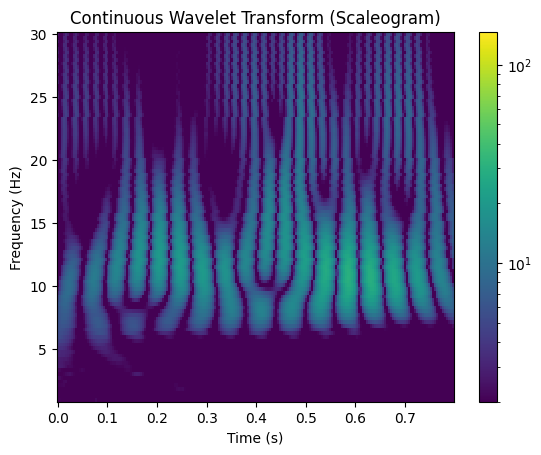

In [26]:
# Create an example CWT
test_cwt = src.cwt_pywt.CWT_PYWT(x_train_windows[:1,0], wavelet = 'morl', vmin=2, vmax=146.1370777320306)
test_cwt.plot_n(0)

In [27]:
def unison_shuffled_copies(a, b):
    assert len(a) == len(b)
    p = np.random.permutation(len(a))
    return a[p], b[p]

x_train_windows, y_train_windows = unison_shuffled_copies(x_train_windows, y_train_windows)
x_valid_windows, y_valid_windows = unison_shuffled_copies(x_valid_windows, y_valid_windows)
x_test_windows, y_test_windows = unison_shuffled_copies(x_test_windows, y_test_windows)

In [28]:
# Save processed data
try:
    with h5py.File('raw.h5', 'w-') as f:
        f.create_dataset('x_train', data = x_train_windows)
        f.create_dataset('x_valid', data = x_valid_windows)
        f.create_dataset('x_test', data = x_test_windows)
        f.create_dataset('y_train', data=y_train_windows, dtype=np.dtype('B'))
        f.create_dataset('y_valid', data=y_valid_windows, dtype=np.dtype('B'))
        f.create_dataset('y_test', data=y_test_windows, dtype=np.dtype('B'))
except FileExistsError:
    pass